# Number Clusters

In [ ]:
import os
import json

layer = 'ViewsLayer'
for r, _, files in os.walk('data/youtube/raw/clusters/'):
    for f in files:
        with open(f'data/youtube/raw/clusters/{f}', 'r') as fh:
            clusters = json.loads(fh.read())
            print(f"{f}: {len(clusters)}")


In [ ]:
len(clusters)

# Class distribution

In [ ]:
import pandas as pd
from pandas import DataFrame

layer = 'LikesLayer'

df = pd.read_csv(f'data/youtube/ml_input/single_context/{layer}.csv', index_col=0)

In [ ]:
df['evolution_label'].value_counts()

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X: np.ndarray = StandardScaler().fit_transform(df)[:,:-1] # all except y
y: pd.Series  = df[df.columns[-1]]

In [ ]:
# Print class sizes
y.value_counts()

In [ ]:
def undersample(X, y, strategy='not minority') -> ('X', 'y'):
    '''Undersampling so all class sizes equal minority class size.'''
    from imblearn.under_sampling import RandomUnderSampler

    rus = RandomUnderSampler(random_state=42, sampling_strategy=strategy)
    X_undersampled, y_undersampled = rus.fit_resample(X, y)

    return X_undersampled, y_undersampled

In [ ]:
def oversample(X, y) -> ('X', 'y'):
    '''Oversample based on SMOTE so all class sizes equal majority class size.'''
    from imblearn.over_sampling import SMOTE

    sm = SMOTE(random_state=42)
    X_oversampled, Y_oversampled = sm.fit_resample(X, y)

    return X_oversampled, Y_oversampled

In [ ]:
import pandas as pd

def sample_median_size(X, y: pd.Series) -> ('X', 'y'):
    '''Sample the median class size for all classes.'''
    median = int(y.value_counts().median())
    sampling_sizes = {k: min(median, y.value_counts()[k]) for k in y.unique()}

    # undersample the larger classes to median size
    X, y = undersample(X, y, strategy=sampling_sizes)
    
    # oversample the smaller classes to median size
    X, y = oversample(X, y)

    return X, y

In [ ]:
X_s, y_s = sample_median_size(X, y)

y_s.value_counts()

# Single-context naive prediction

In [ ]:
import pandas as pd
from pandas import DataFrame

use_case = 'youtube'
layer_name = 'LikesLayer'

df: DataFrame = pd.read_csv(f'data/{use_case}/ml_input/single_context/{layer_name}.csv', index_col=0)
df['evolution_label'] = df['evolution_label'].replace(-1.0, 0)

In [ ]:
simple_df = df[['cluster_size', 'cluster_size.1', 'cluster_size.2', 'evolution_label']]
simple_df

In [ ]:
def get_evolution_label(old_size: int, new_size: int) -> int:
    '''Returns the evolution label as int by mapping 0..4 to {continuing, shrinking, growing, dissolving, forming}.'''
    if old_size == 0 and new_size == 0:
        return 0 # STILL EMPTY
    if old_size == new_size:
        return 0 # continuing
    if old_size == 0 and new_size > 0:
        return 4 # forming
    if old_size > 0 and new_size == 0:
        return 3 # dissolving
    if old_size > new_size:
        return 1 # shrinking
    if old_size < new_size:
        return 2 # growing

In [ ]:
simple_df['prediction'] = simple_df.apply(lambda row: get_evolution_label(old_size=row['cluster_size.1'], new_size=row['cluster_size.2']), axis=1)

In [ ]:
simple_df_test = simple_df.sample(frac=.2).reset_index(drop=True)

In [ ]:
import sklearn.metrics
    
print(sklearn.metrics.classification_report(y_true=simple_df_test['evolution_label'], y_pred=simple_df_test['prediction']))

In [ ]:
test_dataset_frac = .2
dataframe = df
training_size = int(len(dataframe) * (1-test_dataset_frac))

train = dataframe[:training_size]
test = dataframe[training_size:]

Y_train = train[train.columns[-1]]
Y_test = test[test.columns[-1]]

In [ ]:
import sklearn
import statistics as stat
import random

def show_majority_class_prediction():
    print("### Majority Class Prediction: ###")

    majority_class = stat.mode(Y_train)
    try:
        print(f"Training majority class = {stat.mode(Y_train)}, Test majority class = {stat.mode(Y_test)}") 
    except stat.StatisticsError:
        print(f"Label Majority Class: no unique mode; found 2 equally common values")

    pred_Y = len(Y_test) * [majority_class]
    print(sklearn.metrics.classification_report(y_true=Y_test, y_pred=pred_Y))

    
def show_random_prediction():
    print("### Random Class Prediction: ###")

    classes = list(set(Y_train))
    print(f"Classes: {classes}")

    pred_Y = random.choices(classes, k=len(Y_test))
    print(sklearn.metrics.classification_report(y_true=Y_test, y_pred=pred_Y))


show_majority_class_prediction()
show_random_prediction()

# Cross-context naive prediction

In [ ]:
import pandas as pd
from pandas import DataFrame

use_case = 'youtube'
layer_name = 'LikesLayer'
reference_layer_name = 'ViewsLayer'

df: DataFrame = pd.read_csv(f'data/{use_case}/ml_input/cross_context/{layer_name}_{reference_layer_name}.csv', index_col=0)
df['evolution_label'] = df['evolution_label'].replace(-1.0, 0)

In [ ]:
df

In [ ]:
simple_df = df[['n_nodes', 'n_nodes.1', 'evolution_label']]
simple_df

In [ ]:
simple_df['prediction'] = simple_df.apply(lambda row: get_evolution_label(old_size=row['n_nodes'], new_size=row['n_nodes.1']), axis=1)

In [ ]:
simple_df_test = simple_df.sample(frac=.2).reset_index(drop=True)

In [ ]:
import sklearn.metrics
    
print(sklearn.metrics.classification_report(y_true=simple_df_test['evolution_label'], y_pred=simple_df_test['prediction']))

# Community Visualizations

In [1]:
import os
import json
from entities import TimeWindow

dataset = 'taxi'
layer = 'StartLocationLayer'
feature_name = 'likes'

time_windows = []

for r, _, files in os.walk(f'data/{dataset}/raw/timeslices/{layer}'):
    # sort by year, week
    files.sort(key=lambda name: [int(n) for n in name[:-5].split('_')])

    for f in files:
        with open(os.path.join(r, f), 'r') as fh:
            clusters = json.loads(fh.read())

            time_window = TimeWindow.create_from_serializable_dict(clusters)
            time_windows.append(time_window)

In [24]:
from typing import List
import folium

def displayNodes(nodes: List[List[float]]):  
    '''
    Displays the nodes on a map of the city.

    :param nodes: A list of coordinates, eg. [[1,2],[1,3]]
    '''
    m = folium.Map(location=[41.15,-8.6],tiles='stamenterrain',zoom_start=12, control_scale=True) 
    marker_cluster = folium.MarkerCluster().add_to(m)

    for idx, node in enumerate(nodes): 
        popupLabel = idx

        folium.Marker(
          location=[node[1], node[0]],
          #popup='Cluster Nr: '+ str(node.cluster_no),
          popup=popupLabel,
          icon=folium.Icon(color='red', icon='circle'),
        ).add_to(marker_cluster)
      
    display(m)

In [32]:
from typing import List

class Cluster:
    def __init__(self, nodes: List):
        
        calc = ClusterMetricsCalculator2D(nodes, ['start_location_lat', 'start_location_long'], 0 , 0)

        self.nodes = nodes
        self.center = calc.get_center()
        self.size = calc.get_size()

In [15]:
len(time_windows)

53

In [16]:
import matplotlib.pyplot as plt

def plot_clusters(clusters):

    threshold =  12

    plt.figure()
    plt.scatter(
        [c.center[0] for c in clusters if c.size > threshold],
        [c.center[1] for c in clusters if c.size > threshold], 
        s=[c.size*10 for c in clusters if c.size > threshold],
        # c=labels,
        alpha = 0.5)

    plt.show()  

In [71]:
from processing import ClusterMetricsCalculator2D

time_window = time_windows[1]
for time_window in time_windows[2:3]:
    clusters = {}

    for k, nodes in time_window.clusters.items():
        clusters[k] = Cluster(nodes)

    # plot_clusters(clusters)


In [68]:
tw1 = {k:v for k, v in clusters.items() if v.size > 10}

In [74]:
tw2 = {k:v for k, v in clusters.items() if (k in tw1)}

In [80]:
[v.size for k,v  in tw1.items()]

[18, 12, 11, 13, 12, 12]

In [79]:
[v.size for k,v  in tw2.items()]

[9, 6, 9, 9, 8, 10]

In [85]:
X = []
cols = []
for idx, nodes in enumerate([c.nodes for k, c in tw2.items()]):
    X.extend([(n['start_location_lat'], n['start_location_long']) for n in nodes])

    cc = [idx] * len(nodes)
    cols.extend(cc)



In [55]:
X[0]

(-8.58564, 41.148567)

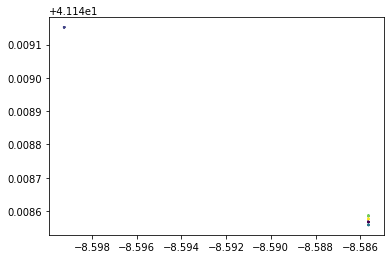

In [59]:
import matplotlib.pyplot as plt
import numpy as np

X = np.asarray(X)

plt.figure()
plt.scatter(
    X[:,0],
    X[:,1], 
    c=cols,
    s=2,
    alpha = 0.5)

plt.show()

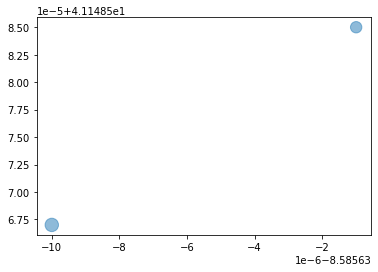

In [21]:
def get_features(time_window):
    X = []

    for k, nodes in time_window.clusters.items():
        nodes = [(n['start_location_lat'], n['start_location_long']) for n in nodes]
        X.extend(nodes)
    
    return X

X = get_features(time_windows[-2])

In [22]:
import numpy as np
X_embedded = np.asarray(X)

In [36]:
# reshape because tsne wants min 2 features
import numpy as np
X = np.array(X).reshape(-1, 1)

In [86]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)

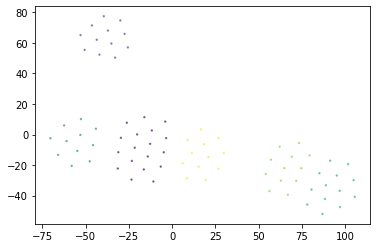

In [60]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(X_embedded[:,0],X_embedded[:,1], 
c=cols,
s=2, alpha = 0.5)

plt.show()

In [90]:
import math

def rotate(point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = (0,0)
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy


In [105]:
newX = []
for p in X_embedded:
    newX.append(rotate(p, math.radians(40)))

newX = np.asarray(newX)

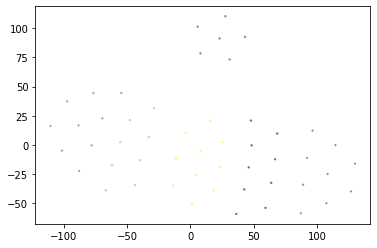

In [106]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(newX[:,0],newX[:,1], 
c=cols,
s=2, alpha = 0.5)

plt.show()

# Community Visualization (reduced)

In [507]:
import os
import json
from entities import TimeWindow

dataset = 'youtube'
layer = 'LikesLayer'
feature_name = 'likes'

time_windows = []

for r, _, files in os.walk(f'data/{dataset}/raw/timeslices/{layer}'):
    # sort by year, week
    files.sort(key=lambda name: [int(n) for n in name[:-5].split('_')])

    for f in files:
        with open(os.path.join(r, f), 'r') as fh:
            clusters = json.loads(fh.read())

            time_window = TimeWindow.create_from_serializable_dict(clusters)
            time_windows.append(time_window)

In [384]:
from typing import List
from processing import ClusterMetricsCalculator1D

class Cluster:
    def __init__(self, nodes: List):
        
        calc = ClusterMetricsCalculator1D(nodes, feature_name, 0 , 0)

        self.nodes = nodes
        self.center = calc.get_center()
        self.size = calc.get_size()

In [514]:
ts_old = 1

In [515]:
time_window = time_windows[ts_old]

clusters = {}

for k, nodes in time_window.clusters.items():
    clusters[k] = Cluster(nodes)


In [516]:
time_window = time_windows[ts_old+1]
    
clusters2 = {}

for k, nodes in time_window.clusters.items():
    clusters2[k] = Cluster(nodes)


In [517]:
class Evolution:
    def __init__(self, k, c1, c2):
        self.k = k
        self.c1 = c1
        self.c2 = c2

In [518]:
threshold = 6
large_keys = [k for k, c in clusters.items() if c.size >= threshold] + [k for k, c in clusters2.items() if c.size >= threshold]
len(large_keys)

596

In [532]:
threshold = 20
large_keys = [k for k, c in clusters.items() if c.size >= threshold] + [k for k, c in clusters2.items() if c.size >= threshold]
large_keys = list(set(large_keys))
large_keys.sort()

old, new = {}, {}

for k in large_keys:
    c1 = clusters[k]
    c2 = clusters2[k]
    # print(k, c1.center[0], ": ", c1.size, c2.size)

    # if abs(c1.size - c2.size) > c1.size*.3 \
    #     and c1.center[0] > 25:
    #     print(c1.center[0])

    old[k] = c1
    new[k] = c2

In [533]:
len(old)

4

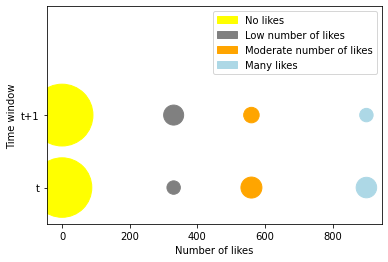

In [542]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

cols = ['lightblue', 'orange', 'grey', 'yellow']*10
size_factor = 20

# old 
sc = ax.scatter(
    [c.center[0]*10 for k, c in old.items()],
    [0 for k, c in old.items()],
    c=cols[:len(old)],
    s=[c.size*size_factor for k, c in old.items()], 
    alpha = 1)

# new 
sc = ax.scatter(
    [c.center[0]*10 for k, c in new.items()],
    [1 for k, c in new.items()],
    c=cols[:len(new)],
    s=[c.size*size_factor for k, c in new.items()], 
    alpha = 1)

plt.yticks([0, 1], ['t', 't+1'])
plt.ylim([-.5, 2.5])

plt.ylabel("Time window")
plt.xlabel("Number of likes")

labels = ['No likes', 'Low number of likes', 'Moderate number of likes', 'Many likes']*10

legend_patches = []
for c, l in zip(cols[::-1][:len(old)], labels[:len(old)]):
    pat = mpatches.Patch(color=c, label=l)
    legend_patches.append(pat)

plt.legend(handles=legend_patches)
plt.show()
plt.show()



In [535]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

# size_factor = 15

# cols = ['blue', 'green', 'red', 'yellow']
# lab = ['No likes', 'Low number of likes', 'Moderate number of likes', 'Many likes']

# for idx, k in enumerate(old.keys()):    
#     ax.scatter(
#         [old[k].center[0], new[k].center[0]],
#         [0, 1],
#         c=cols[idx],
#         s=[old[k].size*size_factor, new[k].size*size_factor], 
#         label=lab[idx],
#         alpha = 0.5)

# plt.legend()

# plt.yticks([0, 1], ['t', 't+1'])
# plt.ylim([-.5, 1.5])

# plt.ylabel("Time window")
# plt.xlabel("Number of likes")

# plt.show()